In [1]:
import sys
from pathlib import Path

# Add the src directory to sys.path
root_dir = Path().absolute().parent.parent
# Add project root to the path of Python
sys.path.append(str(root_dir))

In [2]:
from src import config
from src.config import HopsworksSettings

# Set the environment variables from the file <root_dir>/.env

settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

## 📚 **Descripción del dataset: NYC Open Data - COVID-19 Daily Counts**
Este dataset es proporcionado por el **Department of Health and Mental Hygiene (DOHMH)** de la ciudad de Nueva York y está disponible públicamente a través del portal NYC Open Data

Contiene el recuento diario de residentes de NYC que:
- dieron positivo para SARS-CoV-2.
- fueron hospitalizados con diagnóstico de COVID-19.
- fallecieron debido a esta enfermedad.

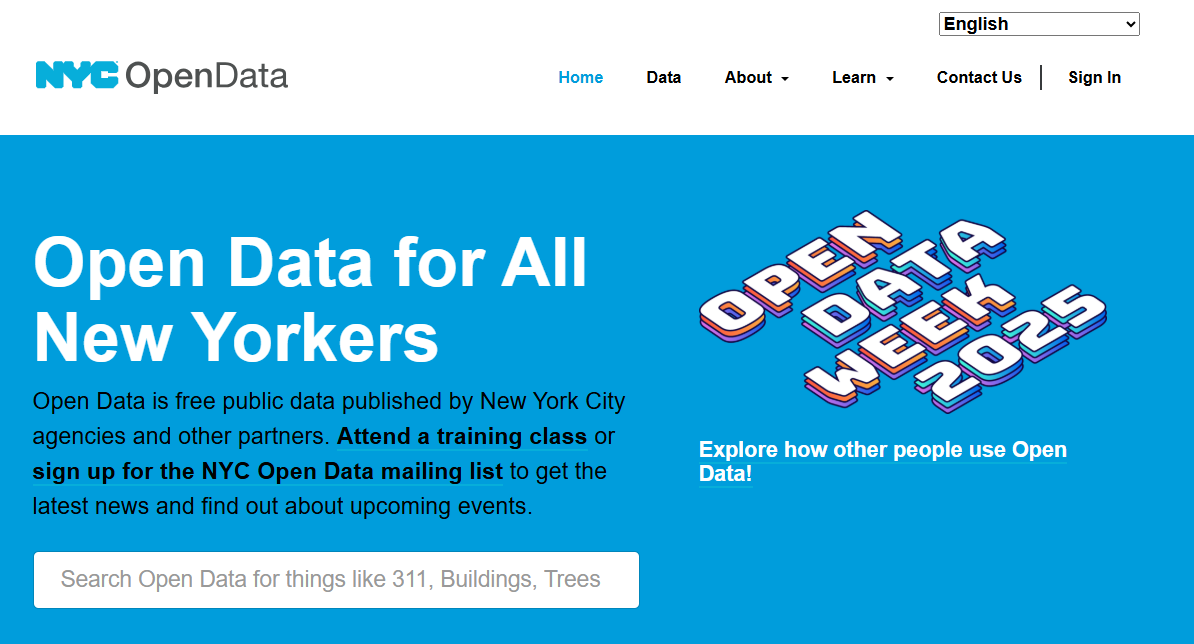

## 🧩 **Parte 01: Feature Backfill for COVID-19 Data in NYC**

### 📝 **Imports**

In [3]:
import datetime
import json

import hopsworks
import pandas as pd
import pandera as pa
from pandera import Column, DataFrameSchema
from sodapy import Socrata

/workspaces/MTA-NYCTrains/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### ***Obtener datos desde NYC Open Data***

**En esta sección se realiza la conexión a la API pública de NYC Open Data para obtener el dataset oficial de conteos diarios de casos, hospitalizaciones y muertes por COVID-19.**

###### 📄 **Nombre del Dataset:** COVID-19 Daily Counts of Cases, Hospitalizations, and Deaths  
###### 🏛️ **Agencia:** Department of Health and Mental Hygiene (DOHMH)  
###### 🔄 **Frecuencia de actualización:** Diaria  
###### 📅 **Fecha de publicación:** 19 de mayo de 2020  
###### 🆕 **Última actualización:** 1 de junio de 2025  

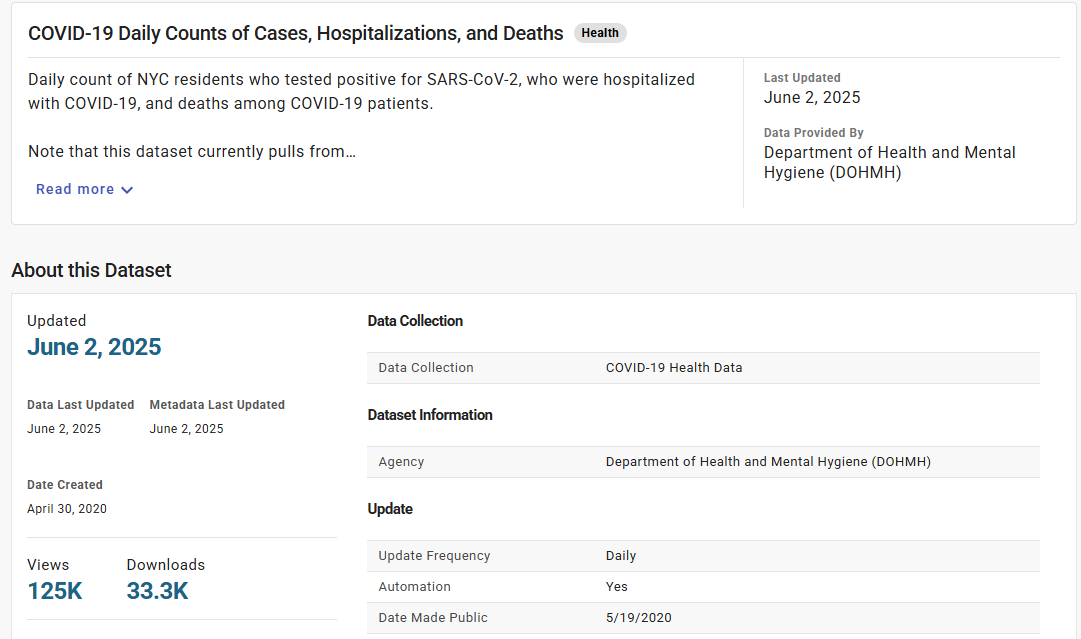

In [4]:
settings = HopsworksSettings()

# Limpia el host en caso de que tenga https://
host_clean = settings.HOPSWORKS_HOST.replace("https://", "").strip("/")

project = hopsworks.login(
    host=host_clean,
    project=settings.HOPSWORKS_PROJECT,
    api_key_value=settings.HOPSWORKS_API_KEY.get_secret_value(),
)

2025-06-02 22:27:43,127 INFO: Initializing external client
2025-06-02 22:27:43,128 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-06-02 22:27:43,602 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1234082


In [5]:
today = datetime.date.today()

csv_file = f"{root_dir}/data/01_raw/covid_raw.csv"

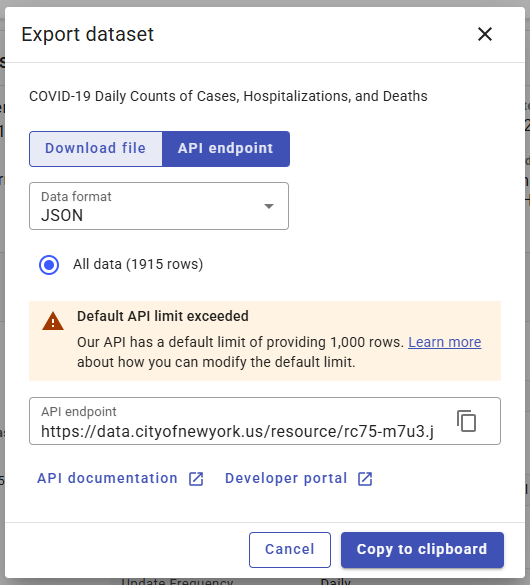

In [6]:
# Cargar configuración desde .env
settings = HopsworksSettings(_env_file=".env")

# Validar NYC_APP_TOKEN
if settings.NYC_APP_TOKEN is None:
    print("You need to set NYC_APP_TOKEN either in this cell or in ~/.env")
    sys.exit(1)

# Obtener valores
NYC_APP_TOKEN = settings.NYC_APP_TOKEN.get_secret_value()
NYC_DATASET_ID = settings.NYC_DATASET_ID
NYC_DEFAULT_LIMIT = settings.NYC_DEFAULT_LIMIT

print(f"✅ Found NYC_APP_TOKEN: {NYC_APP_TOKEN}")
print(f"📊 Dataset ID: {NYC_DATASET_ID} — Limit: {NYC_DEFAULT_LIMIT}")

# Conectarse a Hopsworks
host_clean = settings.HOPSWORKS_HOST.replace("https://", "").strip("/")
project = hopsworks.login(
    host=host_clean,
    project=settings.HOPSWORKS_PROJECT,
    api_key_value=settings.HOPSWORKS_API_KEY.get_secret_value(),
)

# Guardar NYC_APP_TOKEN como secreto en Hopsworks
secrets = hopsworks.get_secrets_api()

existing = secrets.get_secret("NYC_APP_TOKEN")
if existing:
    existing.delete()
    print("♻️ Reemplazando NYC_APP_TOKEN existente")
else:
    print("📭 No existe un secreto NYC_APP_TOKEN todavía")

secrets.create_secret("NYC_APP_TOKEN", NYC_APP_TOKEN)
print("✅ NYC_APP_TOKEN almacenado como secreto en Hopsworks.")

✅ Found NYC_APP_TOKEN: VzGLrB1OwOibEpQiH8jq5Z7cE
📊 Dataset ID: rc75-m7u3 — Limit: 2000
2025-06-02 22:27:43,946 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-06-02 22:27:43,948 INFO: Initializing external client
2025-06-02 22:27:43,949 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-06-02 22:27:44,433 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1234082
♻️ Reemplazando NYC_APP_TOKEN existente
Secret created successfully, explore it at https://c.app.hopsworks.ai:443/account/secrets
✅ NYC_APP_TOKEN almacenado como secreto en Hopsworks.


In [7]:
try:
    client = Socrata("data.cityofnewyork.us", NYC_APP_TOKEN)
    results = client.get(NYC_DATASET_ID, limit=NYC_DEFAULT_LIMIT)
    covid_df = pd.DataFrame.from_records(results)
except Exception as e:
    print("❌ Error al conectar con NYC Open Data. Verifica el NYC_APP_TOKEN y el DATASET_ID.")
    print(f"Detalles del error: {e}")
    covid_df = pd.DataFrame()  # dataframe vacío para evitar errores posteriores

# Mostrar los primeros registros si hay datos
covid_df.head()

,date_of_interest,case_count,probable_case_count,hospitalized_count,death_count,case_count_7day_avg,all_case_count_7day_avg,hosp_count_7day_avg,death_count_7day_avg,bx_case_count,...,si_case_count,si_probable_case_count,si_hospitalized_count,si_death_count,si_probable_case_count_7day_avg,si_case_count_7day_avg,si_all_case_count_7day_avg,si_hospitalized_count_7day_avg,si_death_count_7day_avg,incomplete
0,2020-02-29T00:00:00.000,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-01T00:00:00.000,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-02T00:00:00.000,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-03T00:00:00.000,1,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-03-04T00:00:00.000,5,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Lectura del dataset**

In [8]:
df = pd.read_csv(csv_file, parse_dates=["date_of_interest"], skipinitialspace=True)
df.sort_values(by="date_of_interest", ascending=False)

,date_of_interest,CASE_COUNT,PROBABLE_CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,ALL_CASE_COUNT_7DAY_AVG,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,BX_CASE_COUNT,...,SI_CASE_COUNT,SI_PROBABLE_CASE_COUNT,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,SI_PROBABLE_CASE_COUNT_7DAY_AVG,SI_CASE_COUNT_7DAY_AVG,SI_ALL_CASE_COUNT_7DAY_AVG,SI_HOSPITALIZED_COUNT_7DAY_AVG,SI_DEATH_COUNT_7DAY_AVG,INCOMPLETE
1914,2025-05-27,178,115,12,0,127,198,13,1,31,...,10,9,1,0,5,8,12,1,0,61030
1913,2025-05-26,96,46,15,1,125,193,14,1,20,...,4,6,1,0,4,7,11,1,0,61030
1912,2025-05-25,101,63,9,1,135,212,13,1,13,...,5,3,1,0,4,8,11,1,0,61030
1911,2025-05-24,89,55,18,0,134,209,14,0,12,...,5,6,0,0,4,8,11,1,0,61030
1910,2025-05-23,137,61,12,1,134,209,13,1,20,...,5,0,1,0,3,8,11,1,0,61030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2020-03-04,5,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-03,1,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-02,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-01,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### **Seleccionar las columnas de interés para el proyecto**

In [9]:
# Asegurarte de que la columna de fecha esté correctamente convertida
df["date_of_interest"] = pd.to_datetime(df["date_of_interest"], errors="coerce")

# Lista de columnas numéricas
numeric_columns = [
    "CASE_COUNT",
    "PROBABLE_CASE_COUNT",
    "HOSPITALIZED_COUNT",
    "DEATH_COUNT",
    "CASE_COUNT_7DAY_AVG",
    "ALL_CASE_COUNT_7DAY_AVG",
    "HOSP_COUNT_7DAY_AVG",
    "DEATH_COUNT_7DAY_AVG",
]

# Reemplazar nulos y convertir a int64
df[numeric_columns] = df[numeric_columns].fillna(0).astype("int64")

# Verificar tipos de datos
print(df.dtypes)
df.sample(5)

date_of_interest                   datetime64[ns]
CASE_COUNT                                  int64
PROBABLE_CASE_COUNT                         int64
HOSPITALIZED_COUNT                          int64
DEATH_COUNT                                 int64
CASE_COUNT_7DAY_AVG                         int64
ALL_CASE_COUNT_7DAY_AVG                     int64
HOSP_COUNT_7DAY_AVG                         int64
DEATH_COUNT_7DAY_AVG                        int64
BX_CASE_COUNT                               int64
BX_PROBABLE_CASE_COUNT                      int64
BX_HOSPITALIZED_COUNT                       int64
BX_DEATH_COUNT                              int64
BX_CASE_COUNT_7DAY_AVG                      int64
BX_PROBABLE_CASE_COUNT_7DAY_AVG             int64
BX_ALL_CASE_COUNT_7DAY_AVG                  int64
BX_HOSPITALIZED_COUNT_7DAY_AVG              int64
BX_DEATH_COUNT_7DAY_AVG                     int64
BK_CASE_COUNT                               int64
BK_PROBABLE_CASE_COUNT                      int64


,date_of_interest,CASE_COUNT,PROBABLE_CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,ALL_CASE_COUNT_7DAY_AVG,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,BX_CASE_COUNT,...,SI_CASE_COUNT,SI_PROBABLE_CASE_COUNT,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,SI_PROBABLE_CASE_COUNT_7DAY_AVG,SI_CASE_COUNT_7DAY_AVG,SI_ALL_CASE_COUNT_7DAY_AVG,SI_HOSPITALIZED_COUNT_7DAY_AVG,SI_DEATH_COUNT_7DAY_AVG,INCOMPLETE
341,2021-02-04,4831,1111,435,97,3293,4156,363,82,1071,...,285,69,14,3,51,201,252,16,5,0
1446,2024-02-14,478,265,67,5,482,730,70,5,92,...,35,36,6,0,28,38,67,5,0,0
1107,2023-03-12,215,88,20,7,400,501,35,8,29,...,13,7,0,0,10,28,38,4,1,0
1372,2023-12-02,405,255,56,7,569,931,59,4,73,...,28,20,5,1,33,46,79,5,0,0
1260,2023-08-12,460,293,48,3,609,975,55,1,77,...,30,23,6,0,24,27,51,2,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_of_interest                 1915 non-null   datetime64[ns]
 1   CASE_COUNT                       1915 non-null   int64         
 2   PROBABLE_CASE_COUNT              1915 non-null   int64         
 3   HOSPITALIZED_COUNT               1915 non-null   int64         
 4   DEATH_COUNT                      1915 non-null   int64         
 5   CASE_COUNT_7DAY_AVG              1915 non-null   int64         
 6   ALL_CASE_COUNT_7DAY_AVG          1915 non-null   int64         
 7   HOSP_COUNT_7DAY_AVG              1915 non-null   int64         
 8   DEATH_COUNT_7DAY_AVG             1915 non-null   int64         
 9   BX_CASE_COUNT                    1915 non-null   int64         
 10  BX_PROBABLE_CASE_COUNT           1915 non-null   int64      

##### **Limpieza de nulos**

In [11]:
df.dropna(inplace=True)
df

,date_of_interest,CASE_COUNT,PROBABLE_CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,ALL_CASE_COUNT_7DAY_AVG,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,BX_CASE_COUNT,...,SI_CASE_COUNT,SI_PROBABLE_CASE_COUNT,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,SI_PROBABLE_CASE_COUNT_7DAY_AVG,SI_CASE_COUNT_7DAY_AVG,SI_ALL_CASE_COUNT_7DAY_AVG,SI_HOSPITALIZED_COUNT_7DAY_AVG,SI_DEATH_COUNT_7DAY_AVG,INCOMPLETE
0,2020-02-29,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-01,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-02,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-03,1,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-03-04,5,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910,2025-05-23,137,61,12,1,134,209,13,1,20,...,5,0,1,0,3,8,11,1,0,61030
1911,2025-05-24,89,55,18,0,134,209,14,0,12,...,5,6,0,0,4,8,11,1,0,61030
1912,2025-05-25,101,63,9,1,135,212,13,1,13,...,5,3,1,0,4,8,11,1,0,61030
1913,2025-05-26,96,46,15,1,125,193,14,1,20,...,4,6,1,0,4,7,11,1,0,61030


#### **Definición del esquema**

In [12]:
schema = DataFrameSchema(
    {
        "CASE_COUNT": Column(int, checks=pa.Check.ge(0)),
        "PROBABLE_CASE_COUNT": Column(int, checks=pa.Check.ge(0)),
        "HOSPITALIZED_COUNT": Column(int, checks=pa.Check.ge(0)),
        "DEATH_COUNT": Column(int, checks=pa.Check.ge(0)),
        "CASE_COUNT_7DAY_AVG": Column(int, checks=pa.Check.ge(0)),
        "ALL_CASE_COUNT_7DAY_AVG": Column(int, checks=pa.Check.ge(0)),
        "HOSP_COUNT_7DAY_AVG": Column(int, checks=pa.Check.ge(0)),
        "DEATH_COUNT_7DAY_AVG": Column(int, checks=pa.Check.ge(0)),
    }
)

# Validar DataFrame
validated_df = schema.validate(df)

top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```



In [13]:
fs = project.get_feature_store()

En este bloque se construye un **diccionario** con los metadatos clave del dataset COVID-19.

Este diccionario se convierte en un string JSON y se guarda en **Hopsworks** como un secreto.

Esta estrategia permite mantener los metadatos accesibles para otros notebooks/procesos sin necesidad de codificarlos manualmente.

Si el secreto ya existe, se reemplaza automáticamente.

In [14]:
# Crear el diccionario con los datos clave
covid_dict = {
    "dataset_id": NYC_DATASET_ID,
    "app_token": NYC_APP_TOKEN,
    "limit": NYC_DEFAULT_LIMIT,
    "source": "NYC Open Data",
    "dataset_name": "COVID-19 Daily Counts",
    "url": "https://data.cityofnewyork.us/Health/COVID-19-Daily-Counts-of-Cases-Hospitalizations-an/rc75-m7u3",
}

# Convertirlo a JSON string
str_covid_dict = json.dumps(covid_dict)

# Guardar como secreto en Hopsworks
try:
    secret = secrets.get_secret("COVID_SOURCE_JSON")
    secret.delete()
    print("♻️ Reemplazando secreto COVID_SOURCE_JSON existente")
except (AttributeError, Exception):  # puedes agregar RestAPIError si lo necesitas
    print("📭 No existe un secreto COVID_SOURCE_JSON o no se pudo eliminar")

secrets.create_secret("COVID_SOURCE_JSON", str_covid_dict)
print("✅ COVID_SOURCE_JSON almacenado como secreto en Hopsworks.")

♻️ Reemplazando secreto COVID_SOURCE_JSON existente
Secret created successfully, explore it at https://c.app.hopsworks.ai:443/account/secrets
✅ COVID_SOURCE_JSON almacenado como secreto en Hopsworks.


In [15]:
columns_to_insert = [
    "date_of_interest",  # no olvides incluir la columna temporal
    "CASE_COUNT",
    "PROBABLE_CASE_COUNT",
    "HOSPITALIZED_COUNT",
    "DEATH_COUNT",
    "CASE_COUNT_7DAY_AVG",
    "ALL_CASE_COUNT_7DAY_AVG",
    "HOSP_COUNT_7DAY_AVG",
    "DEATH_COUNT_7DAY_AVG",
]

df_filtered = df[columns_to_insert].copy()

In [16]:
df_filtered["date_of_interest"] = pd.to_datetime(df_filtered["date_of_interest"])
for col in columns_to_insert[1:]:
    df_filtered[col] = df_filtered[col].fillna(0).astype("int64")

In [17]:
covid_fg = fs.get_or_create_feature_group(
    name="covid_daily_counts",
    version=1,
    description="Daily COVID-19 case, hospitalization and death counts in NYC",
    primary_key=["date_of_interest"],
    event_time="date_of_interest",
    online_enabled=False,
)

In [18]:
covid_fg.insert(df_filtered)

Uploading Dataframe: 100.00% |██████████| Rows 1915/1915 | Elapsed Time: 00:00 | Remaining Time: 00:00
Use fg.materialization_job.run(args=-op offline_fg_materialization -path hdfs:///Projects/susiguga/Resources/jobs/covid_daily_counts_1_offline_fg_materialization/config_1748897863875) to trigger the materialization job again.


(Job('covid_daily_counts_1_offline_fg_materialization', 'SPARK'), None)

In [19]:
covid_fg.update_feature_description(
    "date_of_interest", "Date of the daily COVID-19 report (YYYY-MM-DD)"
)
covid_fg.update_feature_description(
    "case_count", "Total number of confirmed COVID-19 cases reported on the date"
)
covid_fg.update_feature_description(
    "probable_case_count",
    (
        "Number of probable COVID-19 cases "
        "(not lab-confirmed, but with clinical or epidemiological evidence)"
    ),
)
covid_fg.update_feature_description(
    "hospitalized_count", "Number of individuals hospitalized with a COVID-19 diagnosis on the date"
)
covid_fg.update_feature_description(
    "death_count", "Number of COVID-19-related deaths reported on the date"
)
covid_fg.update_feature_description(
    "case_count_7day_avg", "7-day moving average of confirmed COVID-19 cases"
)
covid_fg.update_feature_description(
    "all_case_count_7day_avg", "7-day moving average of all COVID-19 cases (confirmed and probable)"
)
covid_fg.update_feature_description(
    "hosp_count_7day_avg", "7-day moving average of COVID-19 hospitalizations"
)
covid_fg.update_feature_description(
    "death_count_7day_avg", "7-day moving average of COVID-19-related deaths"
)

print("✅ Feature group 'covid_daily_counts' created and data inserted successfully.")

✅ Feature group 'covid_daily_counts' created and data inserted successfully.
